In [1]:
import os
import sys
from pathlib import PurePath
this_file_path = PurePath(os.getcwd())
sys.path.append(str(this_file_path.parents[1]))

from typing import Dict, Tuple, List, Union
from collections import namedtuple

import pandas as pd
import numpy as np
import empyrical as ep
from talib import BETA
from scr import LoadData
from hugos_toolkit.BackTestTemplate import get_backtesting
from hugos_toolkit.BackTestReport.tear import analysis_rets, analysis_trade

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

In [2]:
def calc_gsisi(
    close_ser: pd.Series, pivot_swprice: pd.DataFrame, window: int, pct_window: int = 5
) -> pd.Series:
    """投资者情绪指数

    Args:
        close_ser (pd.Series): 默认为沪深300收盘价
        pivot_swprice (pd.DataFrame): 申万收盘数据 index-date columns-swcode values-close
        window (int): sw与close计算beta的窗口
        pct_window (int, optional): 收益率计算窗口. Defaults to 5.

    Returns:
        pd.Series: spearman index-date values-spearman
    """
    # 周度收益
    sw_pct: pd.DataFrame = pivot_swprice.pct_change(pct_window)
    index_pct: pd.Series = close_ser.pct_change(pct_window)

    # 计算beta
    beta_roll5: pd.DataFrame = sw_pct.apply(lambda x: BETA(x, index_pct, window))

    # spearman
    return sw_pct.corrwith(beta_roll5, method="spearman", axis=1)


def get_gsisi_bt(
    index_price: pd.DataFrame,
    pivot_swprice: pd.DataFrame,
    window: int,
    pct_window: int = 5,
    **kw
) -> namedtuple:
    """GSISI回测

    Args:
        index_price (pd.DataFrame): 默认为hs300收盘价 index-date values-close
        pivot_swprice (pd.DataFrame): 申万行业收盘为 index-date columns-sw_code values-close
        window (int): beta与pct的滚动窗口
        pct_window (int, optional): 收益率计算窗口. Defaults to 5.

    Returns:
        namedtuple: bt_result result,cerebro
    """
    data: pd.DataFrame = index_price.copy()
    data["GSISI"] = calc_gsisi(index_price["close"], pivot_swprice, window, pct_window)

    data.dropna(subset=["GSISI"], inplace=True)
    data.index = pd.to_datetime(data.index)

    return get_backtesting(data, "HS300", **kw)


def opt_strat(
    index_price: pd.DataFrame,
    pivot_swprice: pd.DataFrame,
    window: int,
    pct_window: int = 5,
    score_name: str = "_SQN",
    **kw
) -> float:
    """用于寻找参数

    Args:
        index_price (pd.DataFrame): 默认为hs300收盘价 index-date values-close
        pivot_swprice (pd.DataFrame): 申万行业收盘为 index-date columns-sw_code values-close
        window (int): beta与pct的滚动窗口
        pct_window (int, optional): 收益率计算窗口. Defaults to 5.
        score_name (str, optional): 目标参数. Defaults to "_SQN".

    Returns:
        float: 目标参数的数值
    """
    bt_res: namedtuple = get_gsisi_bt(
        index_price, pivot_swprice, window, pct_window, **kw
    )
    anzs = bt_res.result[0].analyzers

    fields: Dict = {
        "_Sharpe": "sharperatio",
        "_SQN": "sqn",
        "_Returns": "rnorm",
    }

    return anzs.getbyname(score_name).get_analysis()[fields[score_name]]

# 投资者情绪指数构建

基本思路是首先计算28个申万一级行业周收益率以及其相对沪深300指数的周Beta系数；然后测算28个申万一级行业周收益率与其周Beta系数的Spearman秩相关系数;最后以Spearman秩相关系数为基础构建国信投资者情绪指数GSISI。

In [3]:
# 数据加载
data = LoadData()

pivot_swprice:pd.DataFrame = data.pivot_swprice
index_price:pd.DataFrame = data.index_price

benchmark_close: pd.Series = index_price["close"]
benchmark_close.index = pd.to_datetime(benchmark_close.index)

In [4]:
# 滚动5日收益率
window1:int = 5
sw_pct:pd.DataFrame = pivot_swprice.pct_change(window1)
index_pct:pd.Series = benchmark_close.pct_change(window1)

window2: int = 50
# 计算beta
beta_roll5: pd.DataFrame = sw_pct.apply(
    lambda x: BETA(x, index_pct, window2)
)

# 计算每个行业与基准的spearman
sw_roll5_pct_rank: pd.DataFrame = sw_pct.rolling(window2).rank()
sw_roll5_beta_rank: pd.DataFrame = beta_roll5.rolling(window2).rank()

sw_spearman: pd.DataFrame = sw_roll5_beta_rank.rolling(window2).corr(sw_roll5_pct_rank)

In [5]:
spearman_roll5: pd.DataFrame = calc_gsisi(benchmark_close, pivot_swprice, window2)

>当国信投资者情绪指数$GSISI \geq 31.7$时,投资乐观情绪上扬；当国信投资者情绪指数$GSISI \leq -31.7$时，投资悲观情绪蔓延。

该阈值来源为:
>对Spearman秩相关系数进行显著性检验,显著性水平$\alpha=0.05$,n=28,查表得Spearman秩相关系数的临界值为0.317

这里我们的申万有31个行业,显著性水平$\alpha=0.05$,n=31,查表临界值应该为0.301

![avatar](https://raw.githubusercontent.com/hugo2046/QuantsPlaybook/dev/C-%E6%8B%A9%E6%97%B6%E7%B1%BB/%E6%8A%95%E8%B5%84%E8%80%85%E6%83%85%E7%BB%AA%E6%8C%87%E6%95%B0%E6%8B%A9%E6%97%B6%E6%A8%A1%E5%9E%8B/img/%E7%A7%A9%E7%9B%B8%E5%85%B3%E7%B3%BB%E6%95%B0%E4%B8%B4%E7%95%8C%E5%80%BC.png)

从数据上来看开平仓标准差不多是信号的2倍标准差,感觉可以使用该数据

均值:0.0032,2 Std:0.3828,-2 Std:-0.3765


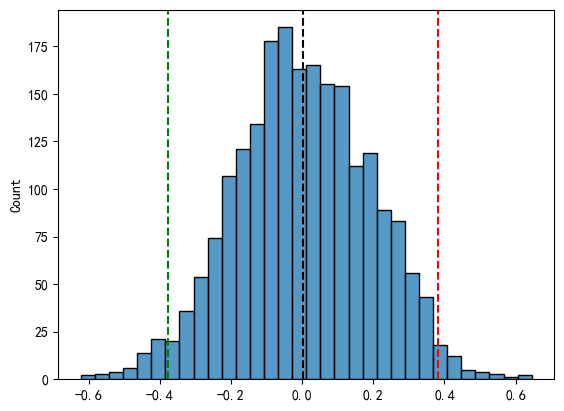

In [6]:
avg:float = spearman_roll5.mean()
std:float = spearman_roll5.std()
std_up:float = avg + std * 2
std_low:float = avg - std * 2

print('均值:{:.4f},2 Std:{:.4f},-2 Std:{:.4f}'.format(avg,std_up,std_low))
ax = sns.histplot(spearman_roll5)
ax.axvline(std_up,ls='--',color='red')
ax.axvline(std_low,ls='--',color='green')
ax.axvline(avg,ls='--',color='black');

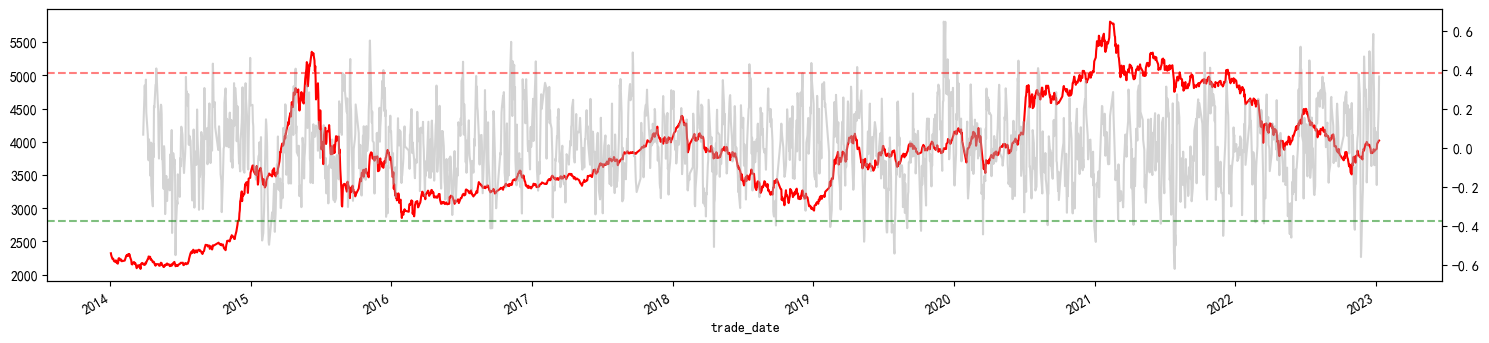

In [7]:
benchmark_close.plot(figsize=(18, 4), color="r", label="Close")
spearman_roll5.plot(color="darkgray", label="GSISI", secondary_y=True, alpha=0.5)
plt.axhline(std_up, ls="--", color="red", alpha=0.5)
plt.axhline(std_low, ls="--", color="green", alpha=0.5);

# GSISI择时模型设计

若GSISI**连续两次**发出看多(或看空)信号,则看多(或看空)沪深300指数,且保持这个判断,直到**连续两次**看空(或看多)信号出现,则发生看空(或看多)沪深300指数的反转判断;若GSISI发出多空交叉互现信号,则除最新信号外,前面的交叉信号作废,以最新信号为判断起点,按照前面两条准则重新分析后面的信号。

**具体步骤是:**

1. 若国信投资者情绪指数$GSISI \geq 0.301$，则作为看多沪深300的一次警示信号.若紧接着再次$GSISI \geq 0.301$，则作为看多沪深300的确认信号,正式看多沪深300,一次判断完成,且保持此判断,直到有相反的判断出现.若紧接着$GSISI \leq -0.301$,则看多沪深300的一次警示信号作废,以此最新的信号为判断起点,进行下一轮的判断.
2. 类似地,若国信投资者情绪指数$GSISI \leq -0.301$，则作为看空沪深300的一次警示信号.若紧接着再次$GSISI \leq -0.301$,则作为看空沪深300的确认信号,正式看空沪深300,一次判断完成,且保持此判断,直到有相反的判断出现.若紧接着$GSISI \geq 0.301$,则看空沪深300的一次警示信号作废,以此最新的信号为判断起点,进行下一轮的判断.

In [8]:
import ipywidgets as ipw

import gradient_free_optimizers as gfo

In [9]:
search_space = {'window': np.arange(5, 100),'pct_window':np.arange(5,21,5)}

iterations = 200

opt = gfo.EvolutionStrategyOptimizer(search_space)
opt.search(lambda x:opt_strat(index_price,pivot_swprice,**x,score_name='_Returns',show_log=False), n_iter=iterations,verbosity=['progress_bar'])

best_params_window = {'window': opt.best_para['window'],'pct_window':opt.best_para['pct_window']}

In [10]:
# _Sharpe/_Returns {'window': 35, 'pct_window': 15} rets 13.01% sharpe 79.76%
# _SQN {'window': 88, 'pct_window': 15} rets 9.11% sharpe 61.07%
bt_res = get_gsisi_bt(index_price,pivot_swprice,**best_params_window)

2014-04-11, 收盘价Close, 2270.67
2014-04-11, 设置买单 BUY CREATE, 2270.67,信号为:0.42,阈值为:0.30
2014-04-14, BUY EXECUTED, ref:1860, Price: 2268.17, Cost: 948951086.94, Comm 189790.22, Size: 418378.00, Stock: HS300
2014-05-29, 收盘价Close, 2155.16
2014-05-29, 设置卖单SELL CREATE, 2155.16信号为:-0.46,阈值为:-0.30
2014-05-30, SELL EXECUTED, ref:1861, Price: 2156.16, Cost: 948951086.94, Comm 1082510.08, Size: -418378.00, Stock: HS300
2014-09-04, 收盘价Close, 2426.22
2014-09-04, 设置买单 BUY CREATE, 2426.22,信号为:0.32,阈值为:0.30
2014-09-05, BUY EXECUTED, ref:1862, Price: 2433.41, Cost: 906955043.97, Comm 181391.01, Size: 372709.00, Stock: HS300
2015-06-26, 收盘价Close, 4336.19
2015-06-26, 设置卖单SELL CREATE, 4336.19信号为:-0.31,阈值为:-0.30
2015-06-29, SELL EXECUTED, ref:1863, Price: 4446.40, Cost: 906955043.97, Comm 1988653.86, Size: -372709.00, Stock: HS300
2015-09-10, 收盘价Close, 3357.56
2015-09-10, 设置买单 BUY CREATE, 3357.56,信号为:0.35,阈值为:0.30
2015-09-11, BUY EXECUTED, ref:1864, Price: 3350.21, Cost: 1611423257.29, Comm 322284.65, Size: 

In [11]:
print(best_params_window)
report2ts = analysis_rets(benchmark_close, bt_res.result, use_widgets=True)
report2trade = analysis_trade(benchmark_close, bt_res.result, use_widgets=True)

{'window': 30, 'pct_window': 15}


d:\anaconda3\lib\site-packages\jupyter_client\session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

d:\anaconda3\lib\site-packages\jupyter_client\session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



In [12]:
box_layout = ipw.Layout(
    display="space-between", border="3px solid black", align_items="inherit"
)

ipw.VBox(
    [   report2ts.risk_table,
        report2ts.cumulative_chart,
        report2trade.position_chart,
        report2trade.pnl_chart,
        report2ts.maxdrawdowns_chart,
    ],
    layout=box_layout,
)

    'data': [{'cells': {'align': [left, center],
                        'font':…

In [13]:
from plotly.offline import iplot
from plotly.offline import init_notebook_mode
init_notebook_mode()

for chart in [   report2ts.risk_table,
        report2ts.cumulative_chart,
        report2trade.position_chart,
        report2trade.pnl_chart,
        report2ts.maxdrawdowns_chart,
    ]:
    iplot(chart)